In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

In [2]:
train_df = pd.read_csv('../data/train_standard_scaled.csv', index_col='DateTime', parse_dates=True)
test_df = pd.read_csv('../data/test_standard_scaled.csv', index_col='DateTime', parse_dates=True)
TARGET_COLUMN = 'Global_active_power'
FEATURES = [col for col in train_df.columns if col != TARGET_COLUMN]
X_train, y_train = train_df[FEATURES], train_df[TARGET_COLUMN]
X_test, y_test = test_df[FEATURES], test_df[TARGET_COLUMN]

In [3]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 24
X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, TIME_STEPS)

In [4]:
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward Part
    ffn = Sequential([Dense(ff_dim, activation="relu"), Dense(inputs.shape[-1])])
    x = ffn(x)
    x = Dropout(dropout)(x)
    res = LayerNormalization(epsilon=1e-6)(x + inputs)
    return res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# Створюємо модель
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
transformer_model = build_transformer_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

transformer_model.compile(optimizer='adam', loss='mean_squared_error')
print("Архітектура Transformer моделі:")
transformer_model.summary()

# Рання зупинка
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nПочинаємо навчання моделі Transformer...")
history = transformer_model.fit(X_train_seq, y_train_seq,
                                epochs=100,
                                batch_size=32,
                                validation_split=0.1,
                                callbacks=[early_stopping],
                                verbose=1)
print("Навчання завершено.")

Архітектура Transformer моделі:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │     31,751 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 7)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 7)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 7)     │         14 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 24, 7)     │         67 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 7)     │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 7)     │          0 │ dropout_2[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 7)     │         14 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │     31,751 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 7)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 7)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 7)     │         14 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 24, 7)     │         67 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 7)     │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 24, 7)     │          0 │ dropout_5[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 7)     │         14 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 7)     │     31,751 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 130,713 (510.60 KB)

 Trainable params: 130,713 (510.60 KB)

 Non-trainable params: 0 (0.00 B)


Починаємо навчання моделі Transformer...
Epoch 1/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - loss: nan - val_loss: nan
Epoch 2/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - loss: nan - val_loss: nan
Epoch 3/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - loss: nan - val_loss: nan
Epoch 4/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 51s 66ms/step - loss: nan - val_loss: nan
Epoch 5/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - loss: nan - val_loss: nan
Epoch 6/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - loss: nan - val_loss: nan
Epoch 7/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - loss: nan - val_loss: nan
Epoch 8/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - loss: nan - val_loss: nan
Epoch 9/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - loss: nan - val_loss: nan
Epoch 10/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: nan - val_loss: nan
Epoch 11/100
777/777 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - loss: nan - val_loss: nan
Навчання завершено.


216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
--- ДІАГНОСТИКА ---
Кількість NaN одразу після прогнозу: 6888
Кількість нескінченних значень (inf): 0
Кількість NaN після очищення: 0
--------------------
NaNs у фінальних фактичних значеннях: 0
NaNs у фінальних прогнозах: 0

Transformer Mean Absolute Error (MAE): 20.21
Transformer Root Mean Squared Error (RMSE): 32.35


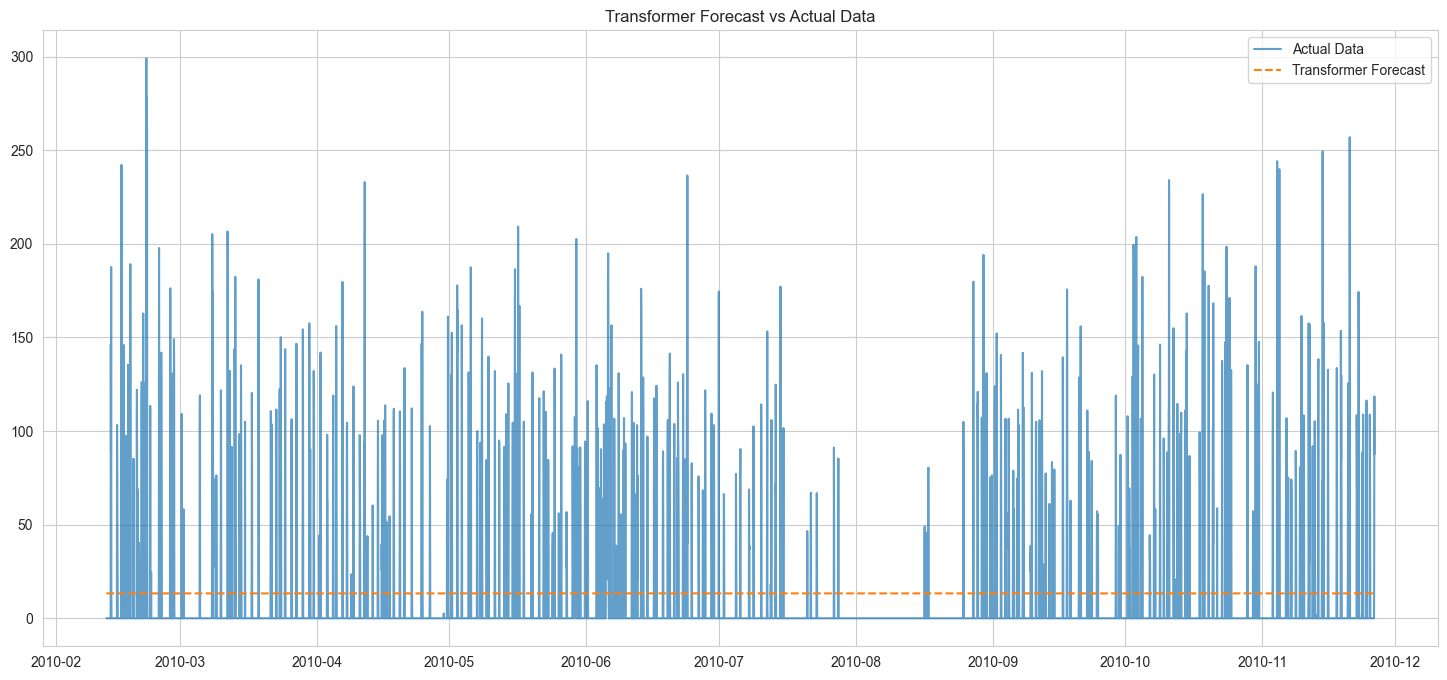

In [5]:
# --- ФІНАЛЬНА ВЕРСІЯ З ДОДАТКОВОЮ ДІАГНОСТИКОЮ ---

# Робимо прогноз на тестових даних
predictions_transformer_scaled = transformer_model.predict(X_test_seq)


# --- ДІАГНОСТИЧНИЙ КРОК 1: Перевіряємо вихід моделі ---
print("--- ДІАГНОСТИКА ---")
print(f"Кількість NaN одразу після прогнозу: {np.isnan(predictions_transformer_scaled).sum()}")
print(f"Кількість нескінченних значень (inf): {np.isinf(predictions_transformer_scaled).sum()}")

# ЗАХИСНИЙ МЕХАНІЗМ: Замінюємо будь-які NaN/inf на 0, щоб уникнути помилок далі
predictions_transformer_scaled = np.nan_to_num(predictions_transformer_scaled)
print(f"Кількість NaN після очищення: {np.isnan(predictions_transformer_scaled).sum()}")
print("--------------------")


# Завантажуємо скейлер, який ми зберегли раніше
scaler = joblib.load('../models/standard_scaler.pkl')

# Готуємо датафрейм для зворотного перетворення
test_df_for_inverse = test_df.iloc[TIME_STEPS:].copy()
target_col_index = test_df.columns.get_loc(TARGET_COLUMN)


# 2. Для прогнозів: вставляємо очищені прогнози в стовпець
test_df_for_inverse[TARGET_COLUMN] = predictions_transformer_scaled.ravel()
# Виконуємо зворотне перетворення
predictions_transformer = scaler.inverse_transform(test_df_for_inverse)[:, target_col_index]

# 3. Для фактичних значень: вставляємо реальні значення
test_df_for_inverse[TARGET_COLUMN] = y_test_seq.ravel()
# Виконуємо зворотне перетворення
y_test_inversed = scaler.inverse_transform(test_df_for_inverse)[:, target_col_index]


# --- Оцінка та Візуалізація ---

# Перевіряємо на NaN ще раз перед розрахунком метрик
print(f"NaNs у фінальних фактичних значеннях: {np.isnan(y_test_inversed).sum()}")
print(f"NaNs у фінальних прогнозах: {np.isnan(predictions_transformer).sum()}")

# Розрахунок метрик
mae_transformer = mean_absolute_error(y_test_inversed, predictions_transformer)
rmse_transformer = np.sqrt(mean_squared_error(y_test_inversed, predictions_transformer))

print(f"\nTransformer Mean Absolute Error (MAE): {mae_transformer:.2f}")
print(f"Transformer Root Mean Squared Error (RMSE): {rmse_transformer:.2f}")

# Візуалізація результатів
plt.plot(test_df.index[TIME_STEPS:], y_test_inversed, label='Actual Data', alpha=0.7)
plt.plot(test_df.index[TIME_STEPS:], predictions_transformer, label='Transformer Forecast', linestyle='--')
plt.title('Transformer Forecast vs Actual Data')
plt.legend()
plt.show()

In [6]:
transformer_model.save('../models/transformer_model.keras')
print("Модель Transformer успішно збережена.")

Модель Transformer успішно збережена.
